<h1> BrainStation Capstone Project</h1>

<b>Is the song "hot enough" for Billboard Hot100 🔥</b>
<br> Predicting the probability of a song reaching the Billboard Hot100 chart.</br>

Author: Hailey Lee
<br>Contact: ejlee.hailey@gmail.com
<br>Date: July 5, 2022

---

# Natural Language Processing (NLP)

This workbook will focus solely on text analysis for our song lyrics. The workbook will take us step by step in pre-processing the data, vectorizing the data, and interpreting the data from various models. We will use TF-IDF ("term frequency-inverse document frequency") to score our tokens (or words) with a built-in feature from sklearn. The last section for topic modeling will use different packages called spaCy and Gensim which also perform similar processes as sklearn's vectorizer.

---
#### Table of Contents:
* [Score Summary](#scores)
* [EDA and Data Cleaning](#edaclean)
* [Data Preprocessing](#preprocess)
* [Text Vectorization](#vect)
* Text Modeling
    * [Logistic Regression](#logreg1)
    * [Dimensionality Reduction with PCA](#dimension)
    * [Logistic Regression with PCA Transformation](#logreg2)
    * [Logistic Regression with GridSearch](#logreg3)
    * [Support Vector Machines](#svm1)
* [Topic Modeling](#lda1)
---

### Score Summary<a class="anchor" id="scores"></a>

|Model | Parameters / Changes | Train Set Score | Test Set Score |
|:-----|:---------------------|:---------------:|:--------------:|
|Logistic Regression | Default | 73.8% | 64.1% |
| Logistic Regression with PCA Transformation | Default | 71.9 % | 64.0% |
| SVM: Linear Support Vector Classifer | Default | 71.3% | 63.2% |
| SVM: Radial Basis Function (RBF) Kernel | Default | 91.9% | 63.8% |
| SVM: Polynomial (poly) Kernel | Default | 98.9% | 59.9% |
| SVM: Sigmoid Kernel | Default | 62.8% | 62.5% |

<br>
<br>

<center>Top 10 keywords predictive of Billboard/Non-Billboard Songs</center>

|   | Positive Coefficients | Negative Coefficients |
|:-:|:----------------------|:----------------------|
|1. | Christmas | Weed |
|2. | Drink | Flow | 
|3. | Truck | Rap | 
|4. | Whiskey | Imma | 
|5. | "Mm" | M************ | 
|6. | Dawg | Disappear |
|7. | Ain't | Grave |
|8. | Beer | Inside | 
|9. | Gang | Homie |
|10.| Opps | Round |

---
### EDA and Data Cleaning<a class="anchor" id="edaclean"></a>

In [2]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns

# for NLP (Natural Language Processing)
from sklearn.feature_extraction.text import TfidfVectorizer
import nltk
from nltk.corpus import stopwords
import re
import spacy
from spacy.lang.en.stop_words import STOP_WORDS
from gensim.models import CoherenceModel, LdaMulticore
from gensim.corpora.dictionary import Dictionary
import pyLDAvis.gensim_models
pyLDAvis.enable_notebook()
import en_core_web_sm

# to run models
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC, LinearSVC
from sklearn.decomposition import PCA, LatentDirichletAllocation
from sklearn.pipeline import Pipeline
from sklearn import set_config
from tempfile import mkdtemp

# ignore warning messages
import warnings
warnings.filterwarnings('ignore')

In [3]:
# import data
songs_df = pd.read_csv('capstone_dataset_clean.csv')
lyrics_df = pd.read_csv('capstone_dataset_lyrics.csv', encoding='latin1')

In [4]:
# look at the shapes of each dataset (rows, columns)
print(f'songs_df shape: {songs_df.shape}')
print(f'lyrics_df shape: {lyrics_df.shape}')

songs_df shape: (13807, 44)
lyrics_df shape: (14024, 5)


In [5]:
# see a sample lyric
[x for x in lyrics_df['lyrics'].sample()]

['Have Yourself a Merry Little Christmas LyricsHave yourself a merry little Christmas\nLet your heart be light\nFrom now on your troubles will be out of sight\nHave yourself a merry little Christmas\nMake the Yuletide gay\nFrom now on your troubles will be miles away\nHere we are as in olden days\nHappy golden days of yore\nFaithful friends who are dear to us\nGather near to us once more\nThrough the years we all will be together\nIf the fates allow\nHang a shining star upon the highest bow\nSo have yourself a merry little Christmas\nHave yourself a merry little Christmas\nSo have yourself a merry little Christmas nowEmbed']

In [6]:
# drop rows without lyrics
print(f'Previous Size: {lyrics_df.shape}')

lyrics_df = lyrics_df.loc[(~lyrics_df['lyrics'].isna()) & (lyrics_df['lyrics'] != '-'), :]

print(f'Current Size: {lyrics_df.shape}')

Previous Size: (14024, 5)
Current Size: (13937, 5)


In [7]:
# pull target and track uri (for merging) & filter rows without track uri
songs_df = songs_df[['billboard','billboard_year', 'billboard_month', 'track_uri']][songs_df['track_uri'] != '-']

# merge by track_uri
songs_lyrics_df = songs_df.merge(lyrics_df, how='left', on='track_uri')

# drop rows that do not have lyrics
songs_lyrics_df.dropna(inplace=True)

# final dataset size
print(f'songs_lyrics_df shape: {songs_lyrics_df.shape}')

songs_lyrics_df shape: (13670, 8)


In [8]:
# sample rows of new dataframe
songs_lyrics_df.sample(5)

,billboard,billboard_year,billboard_month,track_uri,artist,feat_artist,song,lyrics
5930,0,0,0,5zXmmhtXrhDbYnScaYpqZg,Jessie Reyez,-,Imported (with 6LACK),"Hi, my name is, doesn't matter I like making b..."
7806,1,2018,10,3FKj2zOWuAt8wbpv3F2h6b,Lil Wayne,Sosamann,What About Me,"What About Me Lyrics\nIf you saw me, would you..."
6693,1,2019,2,5NfJGBAL9mgFPRQxKJmiX2,Kelsea Ballerini,-,Miss Me More,Miss Me More Lyrics\nI retired my red lipstick...
12983,0,0,0,1bFlyIMhjyZavdg5PXrkLs,Tyga,Blueface,Stash,"Mustard on the beat, ho Pop champagne, put the..."
5274,1,2013,1,7EIbjRAv9K5ccoH4XivnTk,Hunter Hayes,-,Somebody's Heartbreak,Somebody's Heartbreak Lyrics\nI'd love to know...


In [9]:
# check for NaN values and duplicates
null = songs_lyrics_df.isna().sum().sum()
dupes = songs_lyrics_df.duplicated(subset=['track_uri']).sum()

print(f'There are {null} null values.')
print(f'There are {dupes} duplicate values.')

There are 0 null values.
There are 13 duplicate values.


In [10]:
# pull all the duplicate rows
songs_lyrics_df.loc[songs_lyrics_df.duplicated(subset=['track_uri'], keep=False),:].sort_values(by='track_uri')

,billboard,billboard_year,billboard_month,track_uri,artist,feat_artist,song,lyrics
8484,1,2018,2,08bNPGLD8AhKpnnERrAc6G,Marshmello & Anne-Marie,-,Friends,"FRIENDS Lyrics\nOoh-oh, ooh-woh\nOoh-oh, ooh-w..."
8483,1,2018,2,08bNPGLD8AhKpnnERrAc6G,Marshmello,-,FRIENDS,"FRIENDS Lyrics\nOoh-oh, ooh-woh\nOoh-oh, ooh-w..."
5483,1,2016,12,0HtOJj7Kl74s1Ngf3MWeif,J. Cole,-,She's Mine Pt. 1,"She's Mine, Pt. 1 Lyrics[Intro]\nI never felt ..."
5484,1,2016,12,0HtOJj7Kl74s1Ngf3MWeif,J. Cole,-,She's Mine Pt. 2,"She's Mine, Pt. 1 Lyrics[Intro]\nI never felt ..."
11803,1,2013,1,0L4YCNRfXAoTvdpWeH2RGj,Taylor Swift,-,Begin Again,Begin Again Lyrics[Verse 1]\nTook a deep breat...
11802,1,2013,1,0L4YCNRfXAoTvdpWeH2RGj,Taylor Swift,-,Begin Again,Begin Again Lyrics[Verse 1]\nTook a deep breat...
5375,1,2022,5,1r9xUipOqoNwggBpENDsvJ,Imagine Dragons,JID,Enemy,Enemy Lyrics\nLook out for yourself\n\nI wake ...
5378,1,2022,1,1r9xUipOqoNwggBpENDsvJ,Imagine Dragons & JID,-,Enemy,Enemy Lyrics\nLook out for yourself\n\nI wake ...
5377,1,2022,1,1r9xUipOqoNwggBpENDsvJ,Imagine Dragons,JID,Enemy,Enemy Lyrics\nLook out for yourself\n\nI wake ...
5376,1,2022,5,1r9xUipOqoNwggBpENDsvJ,Imagine Dragons & JID,-,Enemy,Enemy Lyrics\nLook out for yourself\n\nI wake ...


In [11]:
# drop the duplicates
songs_lyrics_df.drop_duplicates(subset=['track_uri'], keep='first', inplace=True, ignore_index=False)

In [12]:
# final check
songs_lyrics_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 13657 entries, 0 to 13783
Data columns (total 8 columns):
 #   Column           Non-Null Count  Dtype 
---  ------           --------------  ----- 
 0   billboard        13657 non-null  int64 
 1   billboard_year   13657 non-null  int64 
 2   billboard_month  13657 non-null  int64 
 3   track_uri        13657 non-null  object
 4   artist           13657 non-null  object
 5   feat_artist      13657 non-null  object
 6   song             13657 non-null  object
 7   lyrics           13657 non-null  object
dtypes: int64(3), object(5)
memory usage: 960.3+ KB


### Data Preprocessing<a class="anchor" id="preprocess"></a>

We will pre-process our lyrics before vectorization as there is a lot to clean and modify. The following code will:
- remove song titles and artist names inside the lyrics
- remove words related to music composition
- remove non-ASCII characters
- expand shortened words like *singin'* to *singing*

In [13]:
def preprocess_text(lyrics):
    
    # replace new line characters with whitespace
    lyrics = lyrics.replace('\n', ' ')
        
    # remove song titles
    for song in songs_lyrics_df['song'].unique():
        
        # ignore song titles with less than 3 characters
        if len(song) < 3:
            continue
        else:
            lyrics = lyrics.replace(song,'')
        
    # remove artist names
    for artist in songs_lyrics_df['artist'].unique():
        
        # if artist is less than 3 characters, ignore
        if len(artist) < 3:
            continue
        else:
            lyrics = lyrics.replace(artist,'')
   
    # replace non-ascii characters with space
    lyrics = re.sub("[^\x00-\x7F]+",' ',lyrics)
    
    # lowercase
    lyrics = lyrics.lower()
    
    # replace song structure words
    for structure in ['lyrics','intro', 'verse 1', 'verse 2', 'verse 3', 'verse 4', 'verse', 'verses', 'chorus', 'pre-chorus',
                      'prechorus', 'post-chorus', 'postchorus', 'outro', 'hook', 'bridge', 'embed', 'pre', 'post',
                      'repeat', 'lyric', 'x2', 'x3', 'refrain']:
        lyrics = lyrics.replace(structure,'')
    
    # expand words e.g. singin' to singing
    lyrics = lyrics.replace("in'", "ing")
    lyrics = lyrics.replace("in\'", "ing")
    # but revert " ain't " back to original
    lyrics = lyrics.replace("aingt", "ain't")
        
    return lyrics

In [14]:
# apply function to the dataframe
songs_lyrics_df['lyrics'] = songs_lyrics_df['lyrics'].apply(preprocess_text)

---
### Text Vectorization<a class="anchor" id="vect"></a>

We are using the TF-IDF vectorization method because the Bag-of-Words model only considers the frequency of words. This could lead to bias as songs tend to have many repetitive words. TF-IDF outputs a normalized count and calculates the relative frequency to all the documents. Technically speaking, TF-IDF measures how many times a word appears in a document and the inverse document frequency of the word across a set of documents. The higher the weight of the TF-IDF score, the rarer the term is in a given document and vice versa.

#### Train/Test Split

In [15]:
# assign target variable and features
y = songs_lyrics_df['billboard']
X = songs_lyrics_df.drop(columns='billboard')

# 75/25 split
X_train, X_test, y_train, y_test = train_test_split(X, y, 
                                                    test_size = 0.25,
                                                    random_state = 15)

In [16]:
print(f'X_train has {X_train.shape[0]} rows and {X_train.shape[1]} columns.')
print(f'y_train has {y_train.shape[0]} rows and 1 column.')
print(f'X_test has {X_test.shape[0]} rows and {X_test.shape[1]} columns')
print(f'y_test has {y_test.shape[0]} rows and 1 column.')

X_train has 10242 rows and 7 columns.
y_train has 10242 rows and 1 column.
X_test has 3415 rows and 7 columns
y_test has 3415 rows and 1 column.


In [17]:
# check our features - we'll only need the lyrics column
X_train.columns

Index(['billboard_year', 'billboard_month', 'track_uri', 'artist',
       'feat_artist', 'song', 'lyrics'],
      dtype='object')

#### Text Vectorization

In [18]:
# tokenize the lyrics
X_train['lyrics'].str.split(' ')

# 1. instantiate 
vectorizer = TfidfVectorizer()

# 2. fit 
vectorizer.fit(X_train['lyrics'])

# 3. transform
train_lyrics_transformed = vectorizer.transform(X_train['lyrics'])

X_train has been transformed to a sparse matrix:

In [19]:
train_lyrics_transformed

<10242x44147 sparse matrix of type '<class 'numpy.float64'>'
	with 1275087 stored elements in Compressed Sparse Row format>

But we can always convert it back to a dataframe by transforming it to an array and then attaching the feature names.

In [20]:
pd.DataFrame(columns=vectorizer.get_feature_names(), data=train_lyrics_transformed.toarray())

,00,000,007,01,0121,0128,013,02,03,04,...,zuu,zwei,zwischen,zy,zypitano,zz,zzies,zzy,zzz,zzzzt
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
10237,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
10238,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
10239,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
10240,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


Yikes, we will need to adjust our vectorizer and parameters to find more meaningful keywords. We also need to reduce our dimension as well as there are too many columns vs. the number of rows which can lead to overfitting.

In our custom vectorizer, we will address the following:
- extend stop_words with vocalise (i.e. singing instrumentals like  "ahh" "ooh")
- censor offensive keywords (for project presentation purposes)
- use stemming over lemmatization for speed and simplcity (although this comes at a cost of interpretability)
- replace colloquial words with more recognizable terms and help the stemming process

In [21]:
# create a dictionary of slang words
slang_dict = {
    "cause'":"because",
    "'cause":"because",
    "cause":"because",
    "cuz":"because",
    "'cuz":"because",
    "tryna":"trying",
    "'bout":"about",
    "bout":"about",
    "'cross":"across",
    "dolla":"doller",
    "em":"them",
    "'em":"them",
    "'fore":"before",
    "goin":"going",
    "gon":"going",
    "gon'":"going",
    "lil":"little",
    "lil'":"little",
    "'nother":"another",
    "'nough":"enough",
    "ol'":"old",
    "ol":"old",
    "'spose":"suppose",
    "'round":"around",
    "til":"until",
    "'til":"until",
    "till":"until",
    "togetha":"together",
    "wanna":"want",
    "wit":"with",
    "wit'":"with"
}

In [22]:
# remove common words with built-in stopwords
stop_words = stopwords.words('english')

# instantiate PorterStemmer() to merge similar words
stemmer = nltk.stem.PorterStemmer()

# we will add song structures and vocalise into stopwords
stop_words.extend(['ah', 'ahh', 'oh', 'ohh', 'ooh', 'oo', 'oohooh', 'ohoh', 'la', 'lalala', 'na', 'nanana', 'whoa', 'woah','uh', 'ay', 'ayy', 'woo',
                   'huh', 'eh', 'mmm', 'hmm', 'yuh', 'uhhuh', 'huh', 'aye', 'da', 'di', 'ey', 'uhh', 'um', 'a', 'b', 'c', 'd', 'e', 'f', 'g', 'h',
                   'i', 'j', 'k', 'l', 'm', 'n', 'o', 'p', 'q', 'r', 's', 't', 'u', 'v', 'w', 'x', 'y', 'z', 'im', 'would', 'could','should',
                  'cant', 'dont', 'wont'])

offensive = ['fuck', 'fuckin', 'fucking', 'shit', 'motherfuck', 'mothafuck', 'motherfuckin', 'mothafuckin', 'motherfucking', 'mothafucking', 'bitch',
            'bitches', 'fucker', 'fuckers', 'motherfucker', 'mothafucker', 'motherfuckers', 'mothafuckers', 'fucks', 'shits', 'nigga', 'niggas','ass',
            'pussy', 'bullshit', 'dick', 'bitchass', 'dumbass']

def custom_tokenizer(lyrics):
    # instantiate empty list
    stemmed_words = [] 
    
    # remove special characters (single quote excluded)
    for mark in '!"#$%&\()*+,-./:;<=>?@[\\]^_`{|}~':
        lyrics = lyrics.replace(mark,' ').lower()

    # tokenize each lyric by whitespace or hyphen
    words = re.split(' |-', lyrics)
    
    # replace slang based on slang_dict
    words = [x.replace(x,slang_dict[x]) if x in slang_dict.keys() else x for x in words]
    
    # make lowercase
    for word in words:

        # remove the single quote
        if "'" in word:
            word = word.replace("'","")

        # ignore if word exists in stop_word or is blank
        if (word in stop_words) or (word ==''):
            continue

        else:
            stemmed_word = stemmer.stem(word)
            stemmed_words.append(stemmed_word)
    
    # censor offensive keywords
    stemmed_words = [x.replace(x[2:],'x'*(len(x)-1)) if x in offensive else x for x in stemmed_words]

    return stemmed_words

Before fitting the model, here is a quick overview of the parameters we will be passing through.

[Explanation](https://scikit-learn.org/stable/modules/generated/sklearn.feature_extraction.text.TfidfVectorizer.html) of TfidVectorizer parameters:
- `tokenizer`: we are using a custom tokenizer
- `token_pattern`: passing through regex (regular expression); the argument indicates "up to 3 numbers" + "space" + "any number of letters".
- `min_df`: can be float between 0.0 to 1.0 (for % of documents) or absolute integer (for # of documents). This parameter ignores tokens that appear in *less than* min_df documents.
- `max_df`: can be float between 0.0 to 1.0 (for % of documents) or absolute integer (for # of documents). This parameter ignores tokens that appear in *more than* max_df documents.

In [25]:
# instantiate with new vectorizer
vectorizer = TfidfVectorizer(tokenizer=custom_tokenizer,
                             token_pattern='[0-9]{0,3}.[a-zA-Z]+',
                             min_df=15,
                             max_df=0.95,
                            ngram_range=(1,2))
                             
# fit train set
vectorizer.fit(X_train['lyrics'])

# transform train and test sets
train_lyrics_transformed = vectorizer.transform(X_train['lyrics'])

print(f'There are {train_lyrics_transformed.shape[1]} unique words.')

There are 12554 unique words.


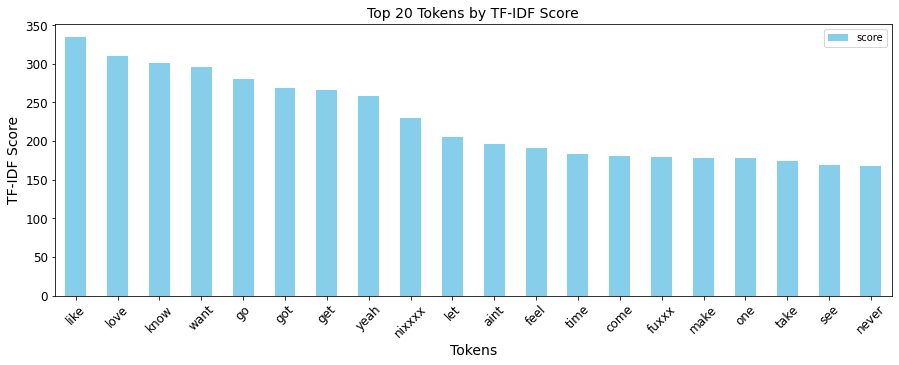

In [26]:
# visualize top 20 tokens

words = vectorizer.get_feature_names()
score = train_lyrics_transformed.toarray().sum(axis=0)

pd.DataFrame({
    'words':words,
    'score':score}).sort_values(by='score', ascending=False).head(20).set_index('words').plot(kind='bar',
                                                                                              rot=45,
                                                                                             color='skyblue',
                                                                                             figsize=(15,5),
                                                                                             fontsize=12)
plt.title('Top 20 Tokens by TF-IDF Score', fontsize=14)
plt.ylabel('TF-IDF Score', fontsize=14)
plt.xlabel('Tokens', fontsize=14)
plt.show()

This is a significant improvement! But we are still dealing with a significant number of features. Let's reduce this a bit with the `min_df` and `max_df` parameters.

In [27]:
# re-run the vectorizer
vectorizer = TfidfVectorizer(tokenizer=custom_tokenizer,
                             token_pattern='[0-9]{0,2}.[a-zA-Z]+',
                             min_df=60,
                             max_df=.85,
                            ngram_range=(1,2))
# fit and transform      
vectorizer.fit(X_train['lyrics'])
train_lyrics_transformed = vectorizer.transform(X_train['lyrics'])

print(f'There are {train_lyrics_transformed.shape[1]} unique words.')

There are 2780 unique words.


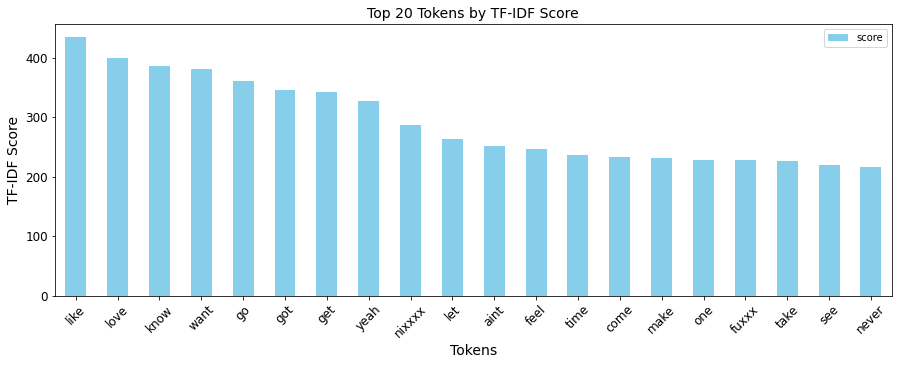

In [28]:
# visualize top 20 tokens

words = vectorizer.get_feature_names()
score = train_lyrics_transformed.toarray().sum(axis=0)

pd.DataFrame({
    'words':words,
    'score':score}).sort_values(by='score', ascending=False).head(20).set_index('words').plot(kind='bar',
                                                                                              rot=45,
                                                                                             color='skyblue',
                                                                                             figsize=(15,5),
                                                                                             fontsize=12)
plt.title('Top 20 Tokens by TF-IDF Score', fontsize=14)
plt.ylabel('TF-IDF Score', fontsize=14)
plt.xlabel('Tokens', fontsize=14)
plt.show()

---
### Modeling: Logistic Regression<a class="anchor" id="logreg1"></a>

Next, we will run a Logistic Regression model with default parameters to set our baseline. However, before running that, we need to make sure our test set is also transformed by our latest vectorizer.

In [29]:
# transform the test set
test_lyrics_transformed = vectorizer.transform(X_test['lyrics'])

In [30]:
# instantiate
log_model = LogisticRegression()

# fit on train set
log_model.fit(train_lyrics_transformed, y_train)

# score
print(f'Train set score: {round(log_model.score(train_lyrics_transformed, y_train)*100,1)}%')
print(f'Test set score: {round(log_model.score(test_lyrics_transformed, y_test)*100,1)}%')

Train set score: 73.8%
Test set score: 64.1%


Let's run a grid search to see if we need to adjust our hyperparameters:

In [31]:
# improve runtime with cached memory
cachedir = mkdtemp()

# set up pieline
pipe = Pipeline([(
    'model', LogisticRegression())],
    memory=cachedir)

# plug in parameters for GridSearch
param_grid = [{
    'model__C': [0.0001, 0.001, 0.01, 0.1, 1, 10, 100, 1000],
    'model__penalty': ['l1', 'l2'],
    'model__solver':['lbfgs','saga']
}]

# set up gridsearch cross validation
grid = GridSearchCV(pipe, param_grid)

# fit train set
fittedgrid = grid.fit(train_lyrics_transformed, y_train)

In [32]:
fittedgrid.best_params_

{'model__C': 1, 'model__penalty': 'l2', 'model__solver': 'lbfgs'}

In [33]:
print(f'Train set best score: {round(fittedgrid.score(train_lyrics_transformed, y_train)*100,1)}%')
print(f'Test set best score: {round(fittedgrid.score(test_lyrics_transformed, y_test)*100,1)}%')

Train set best score: 73.8%
Test set best score: 64.1%


The best model matches our default model except the solver is set at 'saga'. The results have not changed, but we will go ahead and use 'saga' for the following models.

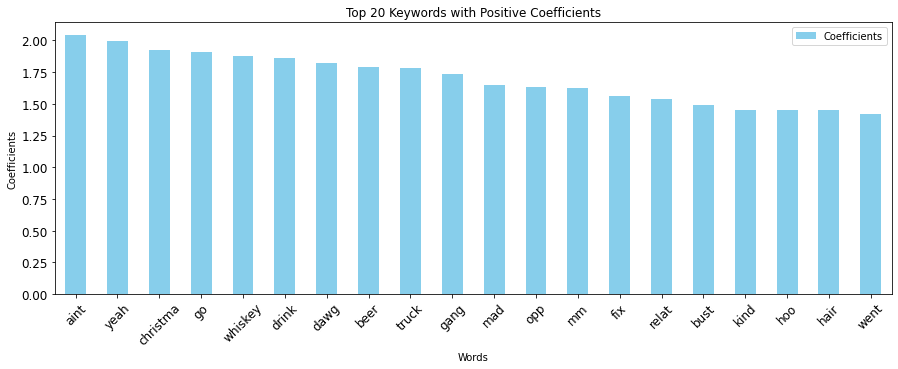

In [34]:
# top 10 tokens with positive coefficients

pd.DataFrame({
    'Words':vectorizer.get_feature_names(),
    'Coefficients':log_model.coef_[0]
}).sort_values(by='Coefficients', ascending=False).head(20).set_index('Words').plot(kind='bar',
                                                                                    rot=45,
                                                                                    color='skyblue',
                                                                                    figsize=(15,5),
                                                                                    fontsize=12)
plt.title('Top 20 Keywords with Positive Coefficients')
plt.ylabel('Coefficients')
plt.show()

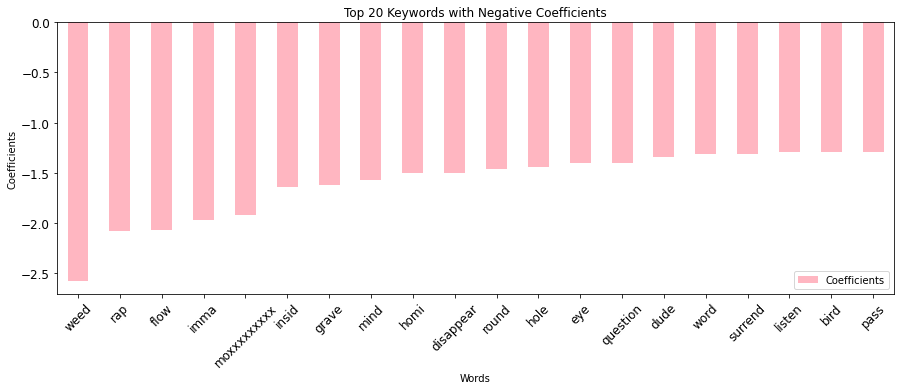

In [35]:
# top 10 tokens with negative coefficients

pd.DataFrame({
    'Words':vectorizer.get_feature_names(),
    'Coefficients':log_model.coef_[0]
}).sort_values(by='Coefficients', ascending=True).head(20).set_index('Words').plot(kind='bar',
                                                                                    rot=45,
                                                                                    color='lightpink',
                                                                                    figsize=(15,5),
                                                                                    fontsize=12)
plt.title('Top 20 Keywords with Negative Coefficients')
plt.ylabel('Coefficients')
plt.show()

By just looking at song lyrics, we were able to achieve a 72.9% accuracy on our train set and 63.6% on our test set. By pulling the coefficients, we can also identify which keywords were most predictive of either class in our target variable. In general we can see that keywords with positive coefficients evoke a fun-spirited/positive vibe (e.g. "Christmas", "whiskey", "skrrt") while the keywords with negative coefficients give off a hardcore/ominous vibe (e.g. offensive words, "grave", "devil")

Note: You can see that some of the words are spelled differently here. That is the downside of `PorterStemmer` in which only the root words are kept and essentially the suffixes are removd; e.g. "danc" is the root for "dance", "dancer", and "dancing".

---
### Dimensionality Reduction: PCA<a class="anchor" id="dimension"></a>

**Principal Component Analysis** achieves two things: reducing dimensionality and removing multicollinearity. Because we have over 2,000+ tokens as features of our dataset, our data is prone to overfitting. What PCA does is it takes the linear combination of our existing features and identifies the direction of greatest variance -- we call this 1st Principal Components. The algorithm repeats the process for given `n_components`. So instead of dropping the feature entirely (and losing that data), PCA helps us keep all our features and just drop the components with least variance. However, the downside is that we lose interpretability since now each component feature is a calculation of all the original features. 

In [36]:
# convert sparse matrices to arrays
train_lyrics_array = train_lyrics_transformed.toarray()
test_lyrics_array = test_lyrics_transformed.toarray()

In [37]:
# fit and transform via PCA

pca = PCA(random_state=15) # default matches original number of features

# fit and transform
pca_train_lyrics = pca.fit_transform(train_lyrics_array)
pca_test_lyrics = pca.transform(test_lyrics_array)

We've just fit and transformed our data through PCA. By default, PCA produces the same number of components as there are features. So how can we choose the right amount of components? There is no right or wrong answer. We can set a threshold (let's say achieve at least 90% of variance) and plot a graph to see where the intersection is.

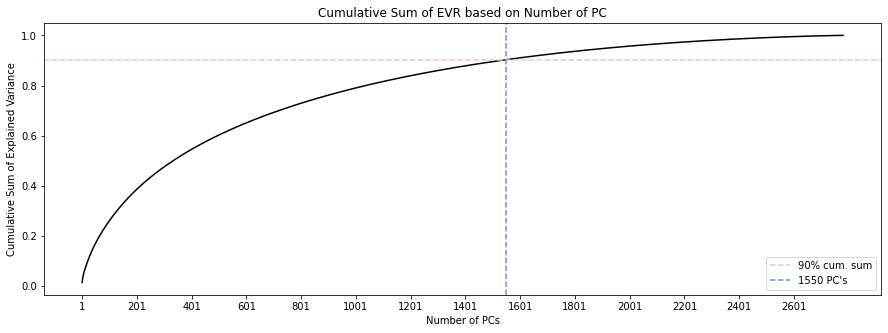

In [44]:
# explained variance ratio
ex_var_ratio = pca.explained_variance_ratio_

# calculate cumulative sum
cumulative_sum = np.cumsum(ex_var_ratio)

# visualize in a grpah
plt.figure(figsize=(15,5))
plt.plot(range(1,len(pca.components_)+1), cumulative_sum, color='black')
plt.xlabel('Number of PCs')
plt.ylabel('Cumulative Sum of Explained Variance')
plt.title('Cumulative Sum of EVR based on Number of PC')
plt.xticks(range(1,len(pca.components_)+1,200))
plt.axhline(.9, linestyle='--', color='pink', label='90% cum. sum')
plt.axvline(1550, linestyle='--', color='cornflowerblue', label="1550 PC's")
plt.legend()
plt.show()

This graph is showing us that 1,550 principal components alone can explain 90% of the variance. The goal is to achieve high % variance but also reduced dimension size. This threshold can achieve both goals. We will re-run the PCA transformation on our data to reduce the number of PCA component features.

In [45]:
print(f'Previous Dimension Size: {pca_train_lyrics.shape[1]}')

pca = PCA(random_state=15,
          n_components=1550)
pca_train_lyrics = pca.fit_transform(train_lyrics_array)
pca_test_lyrics = pca.transform(test_lyrics_array)

print(f'Current Dimension Size: {pca_train_lyrics.shape[1]}')

Previous Dimension Size: 2780
Current Dimension Size: 1550


As mentioned previously, we lose interpretability of our data since each component is a calculation of all the features. However, we can still analyze the actual values of the components which are called *loadings*. With these values, we can see how each original features contributes to given component.

Since we have 1,550 components and 2,780 different tokens, we will only look at the top 5 principal components of greatest variance and a random selection of tokens within them.

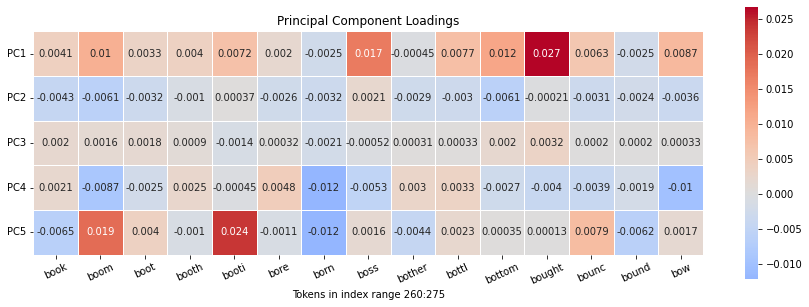

In [47]:
# choose random index range of tokens
idx1 = 260
idx2 = 275

# visualize pca loading with a heatmap by calling .components_ attribute
plt.figure(figsize=(15,5))
ax = sns.heatmap([pca.components_[x][idx1:idx2] for x in range(0,5)],
                 cmap='coolwarm',
                 center=0,
                 yticklabels=["PC"+str(x) for x in range(1,6)],
                 xticklabels=list(vectorizer.get_feature_names()[idx1:idx2]),
                 linewidths = 1,
                 annot = True,
                 cbar_kws={"orientation": "vertical"})

plt.yticks(rotation=0)
plt.xticks(rotation=25)
plt.title('Principal Component Loadings')
plt.xlabel(f'Tokens in index range {idx1}:{idx2}')
ax.set_aspect("equal")

In this sample of loadings, we can see how each word contributes to each PC. When we look at the word "boom", we see that it has a positive relationship to PC1 and PC5 but a negative relationship to PC2 and PC4. And when looking at only PC1, we can say that song lyrics with the words "boss" and "bought" have higher values for PC, while song lyrics with "born" or "bound" have negative values for the same component.

---
### Modeling: Logistic Regression with PCA transformation<a class="anchor" id="logreg2"></a>

Let's try re-running our Logistic Regression with the PCA-transformed data.

In [48]:
# instantiate
log_model = LogisticRegression()

# fit on train set
log_model.fit(pca_train_lyrics, y_train)

# score
print(f'Train set score: {round(log_model.score(pca_train_lyrics, y_train)*100,1)}%')
print(f'Test set score: {round(log_model.score(pca_test_lyrics, y_test)*100,1)}%')

Train set score: 71.9%
Test set score: 64.0%


Our scores dropped slightly. Let's look at the coefficients of our PC's:

In [49]:
# look at top ten positive coefficients
pd.DataFrame(log_model.coef_.T,
             index=['PC'+str(x) for x in range(1,len(log_model.coef_[0])+1)],
             columns=['coefficients']).sort_values(by='coefficients', ascending=False).head(5)

,coefficients
PC1,3.638410
PC2,2.265134
PC14,2.046635
PC301,2.012826
PC4,1.989164


In [50]:
# look at top ten negative coefficients
pd.DataFrame(log_model.coef_.T,
             index=['PC'+str(x) for x in range(1,len(log_model.coef_[0])+1)],
             columns=['coefficients']).sort_values(by='coefficients', ascending=True).head(5)

,coefficients
PC7,-2.695672
PC9,-2.353725
PC44,-2.327489
PC224,-2.247527
PC13,-2.132117


When looking at the coefficients of this Logistic Regression, we can see what kind of relationship each PC has with the model. PC1, PC2, PC14, PC301, PC4 have the highest positive coefficients, meaning their linear combinations of the features are most predictive of class 1 (Billboard). On the contrary, PC7, PC9, PC44, PC224, and PC13 predict the opposite.

---
### GridSearch: Optimize Logistic Regression with PCA Transformed Data<a class="anchor" id="logreg3"></a>

In [51]:
# improve runtime with cached memory
cachedir = mkdtemp()

# set up pieline
pipe = Pipeline([(
    'model', LogisticRegression())],
    memory=cachedir)

# plug in parameters for GridSearch
param_grid = [{
    'model__C': [0.001, 0.01, 0.1, 1, 10, 100],
    'model__penalty': ['l1', 'l2'],
    'model__solver':['lbfgs','saga']
}]

# set up gridsearch cross validation
grid = GridSearchCV(pipe, param_grid)

# fit train set
fittedgrid = grid.fit(pca_train_lyrics, y_train)

In [52]:
# best model
fittedgrid.best_params_

{'model__C': 1, 'model__penalty': 'l2', 'model__solver': 'lbfgs'}

In [53]:
print(f'Train set best score: {round(fittedgrid.score(pca_train_lyrics, y_train)*100,1)}%')
print(f'Test set best score: {round(fittedgrid.score(pca_test_lyrics, y_test)*100,1)}%')

Train set best score: 71.9%
Test set best score: 64.0%


Our test score has not changed, and it looks like we already have our best model with default parameters.

Side note: We can also use GridSearch to find the best parameters for our Vectorizer. Below is a code we can run to find the best balance of `min_df` and `max_df`, along with the best parameters for the Logistic Regression. This requires a bit more computational power and time, so I will leave this as a markdown for now.

```python
# improve runtime with cached memory
cachedir = mkdtemp()

# set up pieline
pipe = Pipeline([
    ('vect', TfidfVectorizer(tokenizer=custom_tokenizer,
                            token_pattern='[0-9]{0,3}.[a-zA-Z]+')),
    ('model', LogisticRegression())],
    memory=cachedir)

# plug in parameters for GridSearch
param_grid = [{
    'vect__min_df':[10,20,30,40,50],
    'vect__max_df':[0.95, 0.9, 0.85, 0.8, 0.75],
    'model__C': [0.001, 0.01, 0.1, 1, 10, 100],
    'model__penalty': ['l1', 'l2'],
    'model__solver':['lbfgs','saga']
}]

# set up gridsearch cross validation
grid = GridSearchCV(pipe, param_grid, verbose=2)

# fit train set
fittedgrid = grid.fit(X_train['lyrics'], y_train)
```

---
### Modeling: Support Vector Machines<a class="anchor" id="svm1"></a>

**SVM**'s (or Support Vector Machines) are also Machine Learning classifiers that focuses on the *distance* (or margin) between the decision boundary and the data points. How strict we want this to be can be adjusted with the $C$ parameter. Like Logistic Regression, SVM has a linear kernel that separates data linearly. But again, SVM's try to maximize margin while Logistic Regression tries to maximize likelihood. What is also unique about SVM models is that there are other kernels that can classify *non-linear* data. As one can imagine, it would not be a surprise if these models output a better score than the linear models. 

A caveat for this blackbox model is interpretability, time to run the models, and setting the various hyperparameters we need to consider. One way around interpreting this model is through [SHAP](https://shap-lrjball.readthedocs.io/en/docs_update/api.html#core-explainers), but given the number of features we have, we will just obtain the baseline scores.

In [54]:
kernels = ['linear', 'poly', 'rbf', 'sigmoid']

for kernel in kernels:
    SVM_model = SVC(kernel=kernel)
    SVM_model.fit(pca_train_lyrics, y_train)
    print(f'Kernel = {kernel}')
    print(f'Train set accuracy: {round(SVM_model.score(pca_train_lyrics, y_train)*100,1)}%')
    print(f'Test set accuracy: {round(SVM_model.score(pca_test_lyrics, y_test)*100,1)}%')
    print('--------------------------------')

Kernel = linear
Train set accuracy: 72.4%
Test set accuracy: 64.0%
--------------------------------
Kernel = poly
Train set accuracy: 98.9%
Test set accuracy: 60.1%
--------------------------------
Kernel = rbf
Train set accuracy: 91.9%
Test set accuracy: 64.7%
--------------------------------
Kernel = sigmoid
Train set accuracy: 64.7%
Test set accuracy: 63.4%
--------------------------------


---
### Topic Modeling<a class="anchor" id="lda1"></a>
This section will cover an unsupervised process of identifying "topics" within our lyrics through a method called Latent Dirichlet Allocation (LDA). Scikit-learn has this included in their package, but we will be using [spaCy](https://spacy.io/) for tokenization/vectorization and [Gensim](https://pypi.org/project/gensim/) for the actual LDA model. The reasons for using these different packages are to explore the differences in use case and Gensim has an amazing topic model visualization feature which we will see at the end.

Quick overview: The LDA algorithm looks at the proportion of words present in a document that are assigned to a topic amongst a pre-determined number of `n_components` topics. It also looks at the topic assignments across all documents. Then, the process is repeated a given number of time to eliminate bias and finalize a stabilized list of topics. LDA can also be used as an alternative way to *reduce dimensionality*. While PCA looks at the linear combination of all the features, LDA similarly looks at all the tokens to create a topic cluster. We can go from a dataframe of thousands of features to a dataframe of a handful of meaningful clusters.

We are going to split the dataframe and **only use the Billboard song lyrics**. Though possible (and time-consuming), it is not common to take an unsupervised LDA model and turn it into a supervised Logistic Regression model. We will find what the most popular themes have been on the Billboard charts.

In [55]:
# split the dataframe to billboard only
billboard = songs_lyrics_df[songs_lyrics_df['billboard'] == 1]

In [56]:
# instantiate
spacy_nlp = spacy.load('en_core_web_sm')

We will update spaCy's stop words (which are a little different from NLTK's). Some of spaCy's stop words are important in expressing sentiment. We will also add custom stop words as we did for the TF-IDF Vectorizer.

You can look what is inside spaCy's default list of stop words by running
```python
from spacy.lang.en.stop_words import STOP_WORDS
print(STOP_WORDS)
```

In [57]:
# customize spaCy's stopwords

# remove from list
STOP_WORDS -= {'never','show', 'us', 'least', 'most', 'noon', 'two', 'hundred', 'same', 'without', 'yours', 'together', 'become', 'top', 'down',
               'whole','until','mine','nobody','please','more','somewhere','anywhere','last','why','bottom','who','ours','sometimes','above',
              'her','against','everything','nothing','you','first','alone','empty','noone','enough','nowhere','no','enough','myself','our'}
# add to list - song structure, vocalise, and single letters
STOP_WORDS |= {'lyrics','lyric','intro','verse','verses','chorus','prechorus','postchorus','outro','hook','bridge','embed','repeat','ah','ahh','oh',
              'ooh','ohh','oo','la','lalala','na','nanana','whoa','woah','uh','ay','woo','huh','eh','mm','mmm','hmm','uhhuh','huh','da','di','ey','um',
              'a','b','c','d','e','f','g','h','i','j','k','l','m','n','o','p','q','r','s','t','u','v','w','x','y','z', 'refrain'}

#### spaCy.pipe is Similar to Sklearn's Vectorizer

In [58]:
# empty list to store tokens
tokens = []

# remove tags
removal = ['PRON','CCONJ','PUNCT','PART','DET','ADP','SPACE', 'NUM', 'SYM']

offensive = ['fuck', 'fuckin', 'fucking', 'shit', 'motherfuck', 'mothafuck', 'motherfuckin', 'mothafuckin', 'motherfucking', 'mothafucking', 'bitch',
            'bitches', 'fucker', 'fuckers', 'motherfucker', 'mothafucker', 'motherfuckers', 'mothafuckers', 'fucks', 'shits', 'nigga', 'niggas','ass',
            'pussy', 'bullshit', 'dick', 'hoe', 'hoes', 'bitchass', 'dumbass']

# run spacy's processing pipline
for summary in spacy_nlp.pipe(billboard['lyrics']):
    
    # equivalent to a vectorizer
    token_list = [token.lemma_.lower() for token in summary \
                if token.pos_ not in removal \
                and not token.is_stop \
                and token.is_alpha \
                and token.is_ascii \
                and not token.is_bracket]
    
    # censor offensive words
    token_list = [x.replace(x[2:],'x'*(len(x)-1)) if x in offensive else x for x in token_list]
    
    tokens.append(token_list)

Similar to how we configured a custom tokenizer for our TF-IDF vectorizer, spaCy has a feature called "pipe" that follows a similar concept. After instantiating `en_core_web_sm` which is an English pipeline trained on written web text (blogs, news, comments), we can configure the tokenizer by calling `token.___`. 
- `.pos_` stands for "part of speech" and uses [universal POS tags](https://universaldependencies.org/u/pos/)
- `is_stop` checks if string is in [stop list](https://github.com/explosion/spaCy/blob/master/spacy/lang/en/stop_words.py)
- `is_alpha` checks if string is alphabetic
- `is_ascii` checks if string has ASCII characters
- `is_bracket` checks if string has square brackets

In [59]:
# create a new feature in dataframe with tokens
billboard['tokens'] = tokens

# preview
billboard['tokens']

5        [rybody, ryone, listen, hey, hey, hey, hey, he...
7        [nixxxx, get, fuxxx, cap, yuh, yuh, dee, b, ge...
32       [yeah, yeah, m, m, m, murda, yeah, damn, right...
33       [murda, beat, nice, vip, squad, drop, gang, vi...
34       [birthday, birthday, die, bury, ls, store, ha,...
                               ...                        
13763    [night, know, upside, down, hold, tongue, hear...
13764    [seat, right, sit, stair, leave, cabinet, bare...
13765    [fall, foot, ground, reach, er, pull, rein, le...
13769    [stop, sound, good, more, turn, turn, know, kn...
13770    [wanna, try, night, wanna, try, night, know, g...
Name: tokens, Length: 6775, dtype: object

In [62]:
# import Dictionary from Gensim and map token to unique ID
token_dict = Dictionary(billboard['tokens'])

print(f'There are {len(token_dict)} tokens in the dictionary.')

There are 27163 tokens in the dictionary.


In [63]:
print(f'Previous size: {len(token_dict)} tokens')

# filter dictionary - similar to min_df and max_df
token_dict.filter_extremes(no_below=35, no_above=0.85, keep_n=3000)

print(f'Current size: {len(token_dict)} tokens')

Previous size: 27163 tokens
Current size: 2039 tokens


#### How to choose the right number of topics?

The hyperparameter for the LDA model is essentially the number of topics. To determine the optimal number of topics, we use a metric called the *coherence score*. When we talk about a "coherent sentence", we are referring to the words within that sentence and whether or not they support each other for a holistic idea. Topic coherence does the same thing by "measuring the degree of semantic similarity between high scoring words in the topic." ([source](https://towardsdatascience.com/evaluate-topic-model-in-python-latent-dirichlet-allocation-lda-7d57484bb5d0))

To run the LDA model, we need to create a corpus. We can accomplish this with the doc2bow feature from Gensem. The documentation states that it "converts document into the bag-of-words (BoW) format = list of (token_id, token_count) tuples."

In [65]:
# word count mapped to integer word id, outputting a sparse vector
corpus = [token_dict.doc2bow(doc) for doc in billboard['tokens']]

The format of the LDA model from Gensim is a little different than sklearn's:
```python
lda_model = LdaMulticore(corpus=corpus,      # input corpus
                         id2word=token_dict, # input token dictionary
                         iterations=50,      # number of iternations over corpus to optimize model; default = 50
                         num_topics=10,      # number of topics (hyperparameter)
                         workers = 4,        # number of cores on PC
                         passes=10)          # number of times for model to pass through corpus

```

We will run the coherence scores first to determine what to pass through `num_topics`. There are several different coherence measures based on how they are calculated. There is no best or correct calculation, but the most popular uses are `u_mass` and `c_v`. We will try running each one to determine the best of both worlds.

The following cells will plot the c_v and u_mass scores based on number of numbers. c_v will range from $0<x<1$ and u_mass will range from $-14<x<14$. You will also see from the plots that both are "inverses" of each other. The overall coherence score of a topic represent the average distance between the words.

Further reading on how c_v and u_mass are calculated can be found [here](https://www.baeldung.com/cs/topic-modeling-coherence-score) and [here](https://towardsdatascience.com/evaluate-topic-model-in-python-latent-dirichlet-allocation-lda-7d57484bb5d0).

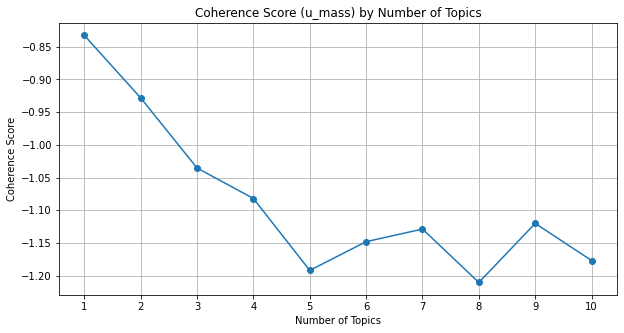

In [66]:
# get coherence score using u_mass
topics = []
umass_score = []

for i in range(1,11):
    lda_model = LdaMulticore(corpus=corpus,
                             id2word=token_dict,
                             iterations=25,
                             num_topics=i,
                             workers = 4,
                             passes=15,
                             random_state=12)

    coher_model = CoherenceModel(model=lda_model,
                                 corpus=corpus,
                                 dictionary=token_dict,
                                 coherence='u_mass')
    topics.append(i)
    umass_score.append(coher_model.get_coherence())

# visualize coherence score for umass
plt.figure(figsize=(10,5))
plt.plot(topics, umass_score, marker='o')
plt.xlabel('Number of Topics')
plt.ylabel('Coherence Score')
plt.title('Coherence Score (u_mass) by Number of Topics')
plt.xticks(range(1,11))
plt.grid()
plt.show()

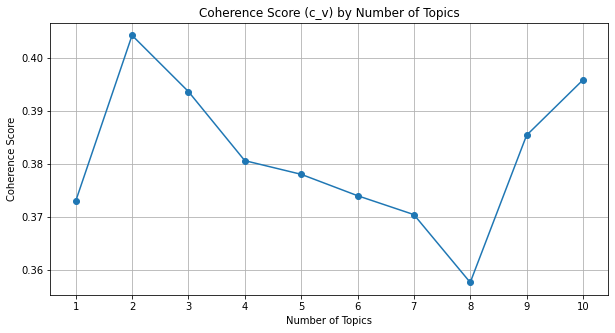

In [67]:
# get coherence score using c_v
topics = []
cv_score = []

for i in range(1,11):
    lda_model = LdaMulticore(corpus=corpus,
                            id2word=token_dict,
                            iterations=20,
                            num_topics=i,
                            workers = 4,
                            passes=10,
                            random_state=15)

    coher_model = CoherenceModel(model=lda_model,
                                 texts = billboard['tokens'],
                                 corpus=corpus,
                                 dictionary=token_dict,
                                 coherence='c_v')
    topics.append(i)
    cv_score.append(coher_model.get_coherence())
    
# visualize coherence score for C_v
plt.figure(figsize=(10,5))
plt.plot(topics, cv_score, marker='o')
plt.xlabel('Number of Topics')
plt.ylabel('Coherence Score')
plt.title('Coherence Score (c_v) by Number of Topics')
plt.xticks(range(1,11))
plt.grid()
plt.show()

Based on the scores above, the optimal choice appears to be at `num_topics=2`. While these scores are just a guidance, we will run the LDA model for four topics as we know that the Billboard charts can cover a variety of topics. Based on the graphs, four is the max number of topics before hitting very low coherence scores.

What we want to ensure in the visualization below is that each topic is distinct and not overlapping. We can also tweak the relevance parameter to view most frequent or most relevant keywords to determine the topic.

In [70]:
# re-run model with optimized parameter
lda_model = LdaMulticore(corpus=corpus,
                         id2word=token_dict,
                         iterations=100,
                         num_topics=4,
                         workers = 4,
                         passes=100,
                        random_state=15)

#### Understanding the visualization:
- Each bubble in the graph represents a single topic.
- The distance between each bubble represent how distinct the topics are.
- The size the bubble indicates a higher percentage of tokens in the corpus about that topic.
- The blue bar graph on the right is the total count of each token. When you select a topic, the bars will turn red indicating the number of times that token was generated by that specific topic.
- On the top-right, lambda is the relevance parameter that ranges from $0 \leq \lambda \leq 1$. This is an adjustable parameter that balances a term’s frequency in a particular topic against the its frequency across the entire corpus. In essence, if we lower $\lambda$, we are penalizing the terms that just happens to be frequent in any topic, resulting in words that are more exclusive to that given topic.

In [71]:
# visualize topics
lda_display = pyLDAvis.gensim_models.prepare(lda_model, corpus, token_dict)
pyLDAvis.display(lda_display)

In [72]:
# save to html
pyLDAvis.save_html(lda_display,'lda_model_billboard.html')

Great! Our topics are not overlapping and each bubble represents a unique topic. Play looking at each bubble and adjusting the relevance parameter, we can come to the following conclusions about the topic:
1. Romance / Heartbreak Songs
    - Top tokens: (λ=0.6) love, heart, time, feel, never
2. Hardcore / Life
    - Top tokens: (λ=0.3) god, man, know, die, real
3. Explicit / Fiesta songs
    - Top tokens: (λ=0.6) <explicit language>, "ayy", money, lil, pop
4. Sexy Love Songs
    - Top tokens: (λ=1.0) girl, baby, wanna, night, dance

In [73]:
# adding topics to dataframe
billboard['topic'] = [sorted(lda_model[corpus][text])[0][0] for text in range(len(billboard['tokens']))]

We will analyze this further in the Data Visualization Workbook that came with this project.

In [74]:
import pickle

# save to pickle to load into Data Visualization Workbook
billboard.to_pickle('topic_model.pkl')

---

<center>2022 BrainStation Capstone Project
    <br>"Is the song <i>hot enough</i> for Billboard Hot100?"
    <br>by Hailey Lee</center>